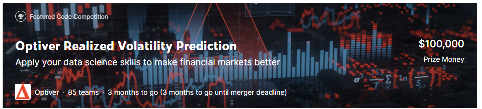

thanks https://www.kaggle.com/mayunnan/realized-volatility-prediction-code-template

## June 28, 2021 - Start Date<br>
## September 27, 2021 - Final submission deadline.

In [ ]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Train data read</span>

In [ ]:
train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train.head()

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Book data read</span>

In [ ]:
book = pd.read_parquet('../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0/c439ef22282f412ba39e9137a3fdabac.parquet')
book

<pre>
stock_id - ID code for the stock. Not all stock IDs exist in every time bucket. Parquet coerces this column to the categorical data type when loaded; you may wish to convert it to int8.
time_id - ID code for the time bucket. Time IDs are not necessarily sequential but are consistent across all stocks.
seconds_in_bucket - Number of seconds from the start of the bucket, always starting from 0.
bid_price[1/2] - Normalized prices of the most/second most competitive buy level.
ask_price[1/2] - Normalized prices of the most/second most competitive sell level.
bid_size[1/2] - The number of shares on the most/second most competitive buy level.
ask_size[1/2] - The number of shares on the most/second most competitive sell level.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Book data Analyze</span>

In [ ]:
check = book[book.time_id==5]
check

In [ ]:
trade = pd.read_parquet('../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0/ef805fd82ff54fadb363094e3b122ab9.parquet')
trade.head()

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Book size Analyze</span>

In [ ]:
check_trade = trade[trade.time_id==5]
#samples = ["bid_size1","bid_size2","ask_size1","ask_size2"]
samples = ["bid_size1","ask_size1"]

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["seconds_in_bucket"],check[idx],label=idx)
plt.plot(check_trade["seconds_in_bucket"],check_trade["size"],label="trade_parquet")
plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Price Analyze</span>

In [ ]:
check_trade = trade[trade.time_id==5]
samples = ["bid_price1","bid_price2","ask_price1","ask_price2"]

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["seconds_in_bucket"],check[idx],label=idx)

plt.plot(check_trade["seconds_in_bucket"],check_trade["price"],label="trade_parquet")
plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Order Analyze</span>

In [ ]:
plt.figure(figsize=(20,5))
check_trade = trade[trade.time_id==5]
plt.plot(check_trade["seconds_in_bucket"],check_trade["order_count"],label="trade_parquet")
plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">wap1/wap2</span>

In [ ]:
plt.figure(figsize=(20,5))
wap1 = (check['bid_price1'] * check['ask_size1'] + check['ask_price1'] * check['bid_size1']) / (check['bid_size1'] + check['ask_size1'])
wap2 = (check['bid_price2'] * check['ask_size2'] + check['ask_price2'] * check['bid_size2']) / (check['bid_size2'] + check['ask_size2'])
check['wap1'] = wap1
check['wap2'] = wap2
plt.plot(check["seconds_in_bucket"],wap1,label="wap1")
plt.plot(check["seconds_in_bucket"],wap2,label="wap2")
plt.legend(fontsize=12)

In [ ]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">log_return</span>

In [ ]:
    plt.figure(figsize=(20,5))
    check['log_return1'] = check.groupby(['time_id'])['wap1'].apply(log_return)
    check['log_return2'] = check.groupby(['time_id'])['wap2'].apply(log_return)
    plt.plot(check["seconds_in_bucket"],check['log_return1'],label="log_return1")
    plt.plot(check["seconds_in_bucket"],check['log_return2'],label="log_return2")
    plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Price spred</span>

In [ ]:
    plt.figure(figsize=(20,5))
    check['price_spread'] = ( check['ask_price1'] - check['bid_price1']) / (( check['ask_price1'] +  check['bid_price1']) / 2)
    check['price_spread2'] = ( check['ask_price2'] -  check['bid_price2']) / (( check['ask_price2'] +  check['bid_price2']) / 2)
    check['bid_spread'] = check['bid_price1'] - check['bid_price2']
    check['ask_spread'] = check['ask_price1'] - check['ask_price2']
    plt.plot(check["seconds_in_bucket"],check['price_spread'],label="price_spread")
    plt.plot(check["seconds_in_bucket"],check['price_spread2'],label="price_spread2")
    plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Bid/Ask spread</span>

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['bid_spread'],label="bid_spread")
    plt.plot(check["seconds_in_bucket"],check['ask_spread'],label="ask_spread")
    plt.legend(fontsize=12)

In [ ]:
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = check[check['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    def log_return(series):
        return np.log(series).diff()

    # Calculate the realized volatility
    def realized_volatility(series):
        return np.sqrt(np.sum(series**2))

    def count_unique(series):
        return len(np.unique(series))# Function to read our base train and test set

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Probability Density Fuction</span>

In [ ]:
from scipy.stats import norm
plt.figure(figsize=(20,5))
plt.plot(check_trade["seconds_in_bucket"],check_trade["price"].apply(lambda x: norm.pdf(x)),label="trade_parquet")
plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Cumculative Disribution Function</span>

### Point graph

You can see how many times the standard deviation moves.

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(check_trade["seconds_in_bucket"],check_trade["price"].apply(lambda x: norm.cdf(x)),label="trade_parquet")
plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">T distribution</span>

In [ ]:
from scipy.stats import t
plt.figure(figsize=(20,5))
plt.plot(check_trade["seconds_in_bucket"],check_trade["price"].apply(lambda x: t.pdf(x,df=1)),label="trade_parquet")
plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">X**2 Distribution</span>

In [ ]:
from scipy.stats import chi2
plt.figure(figsize=(20,5))
plt.plot(check_trade["seconds_in_bucket"],check_trade["price"].apply(lambda x: chi2.pdf(x,df=1)),label="trade_parquet")
plt.legend(fontsize=12)

In [ ]:
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    #add
    df['h_spread_l1'] = df['ask_price1'] - df['bid_price1']
    df['h_spread_l2'] = df['ask_price2'] - df['bid_price2']
    df['v_spread_b'] = df['bid_price1'] - df['bid_price2']
    df['v_spread_a'] = df['ask_price1'] - df['ask_price2'] 
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std,np.min,np.max,np.median], 
        'wap2': [np.sum, np.mean, np.std,np.min,np.max,np.median], 
        'log_return1': [np.sum, realized_volatility, np.mean, np.std,np.min,np.max],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std,np.min,np.max],
        'wap_balance': [np.sum, np.mean, np.std,np.min,np.max],
        'price_spread':[np.sum, np.mean, np.std,np.min,np.max],
        'price_spread2':[np.sum, np.mean, np.std,np.min,np.max],
        'bid_spread':[np.sum, np.mean, np.std,np.min,np.max],
        'ask_spread':[np.sum, np.mean, np.std,np.min,np.max],
        'total_volume':[np.sum, np.mean, np.std,np.min,np.max],
        'volume_imbalance':[np.sum, np.mean, np.std,np.min,np.max],
        "bid_ask_spread":[np.sum, np.mean, np.std,np.min,np.max],
        'h_spread_l1':[np.sum, np.mean, np.std,np.min,np.max],
        'h_spread_l2':[np.sum, np.mean, np.std,np.min,np.max],
    }
        # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
    #df_feature_500 = get_stats_window(seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)
    df_feature_100 = get_stats_window(seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    #df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    
    return df_feature



In [ ]:
data_dir = '../input/optiver-realized-volatility-prediction/'
stock_id='0'
file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
check = book_preprocessor(file_path_book)
check.head()        

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">log_return_realized_volatility</span>

In [ ]:
    check = check[:100]
    check["seconds_in_bucket"] = range(len(check))
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['log_return1_realized_volatility'],label="log_return1_realized_volatility")
    plt.plot(check["seconds_in_bucket"],check['log_return1_realized_volatility_450'],label="log_return1_realized_volatility_450")
    plt.plot(check["seconds_in_bucket"],check['log_return1_realized_volatility_300'],label="log_return1_realized_volatility_300")
    plt.legend(fontsize=12)


In [ ]:

    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['log_return2_realized_volatility'],label="log_return2_realized_volatility")
    plt.plot(check["seconds_in_bucket"],check['log_return2_realized_volatility_450'],label="log_return2_realized_volatility_450")
    plt.plot(check["seconds_in_bucket"],check['log_return2_realized_volatility_300'],label="log_return2_realized_volatility_300")
    #plt.plot(check["seconds_in_bucket"],check['log_return2_realized_volatility_400'],label="log_return2_realized_volatility_400")
    plt.plot(check["seconds_in_bucket"],check['log_return2_realized_volatility_150'],label="log_return2_realized_volatility_150")
    plt.legend(fontsize=12)

In [ ]:

    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['log_return2_realized_volatility'],label="log_return2_realized_volatility")
    plt.plot(check["seconds_in_bucket"],check['log_return2_realized_volatility_450'],label="log_return2_realized_volatility_400")
    plt.plot(check["seconds_in_bucket"],check['log_return2_realized_volatility_300'],label="log_return2_realized_volatility_300")
    plt.plot(check["seconds_in_bucket"],check['log_return2_realized_volatility_400'],label="log_return2_realized_volatility_200")
    plt.plot(check["seconds_in_bucket"],check['log_return2_realized_volatility_150'],label="log_return2_realized_volatility_100")
    plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">wap sum</span>

### wap1/wap2 are same

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['wap1_sum'],label="wap1")
    plt.plot(check["seconds_in_bucket"],check['wap2_sum'],label="wap2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['wap1_std'],label="wap1")
    plt.plot(check["seconds_in_bucket"],check['wap2_std'],label="wap2")
    plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">wap mean</span>

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['wap1_mean'],label="wap1")
    plt.plot(check["seconds_in_bucket"],check['wap2_mean'],label="wap2")
    plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">wap median</span>

### I think almost same as mean

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['wap1_median'],label="wap1")
    plt.plot(check["seconds_in_bucket"],check['wap2_median'],label="wap2")
    plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">wap min/max</span>

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['wap1_amin'],label="wap1")
    plt.plot(check["seconds_in_bucket"],check['wap2_amin'],label="wap2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['wap1_amax'],label="wap1")
    plt.plot(check["seconds_in_bucket"],check['wap2_amax'],label="wap2")
    plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">log_return</span>

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['log_return1_mean'],label="log1")
    plt.plot(check["seconds_in_bucket"],check['log_return2_mean'],label="log2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['log_return1_std'],label="log1")
    plt.plot(check["seconds_in_bucket"],check['log_return2_std'],label="log2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['log_return1_amin'],label="log1")
    plt.plot(check["seconds_in_bucket"],check['log_return2_amin'],label="log2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['log_return1_amax'],label="log1")
    plt.plot(check["seconds_in_bucket"],check['log_return2_amax'],label="log2")
    plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">price speed</span>

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['price_spread_mean'],label="price_spread")
    plt.plot(check["seconds_in_bucket"],check['price_spread2_mean'],label="price_spread2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['price_spread_std'],label="price_spread")
    plt.plot(check["seconds_in_bucket"],check['price_spread2_std'],label="price_spread2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['price_spread_sum'],label="price_spread")
    plt.plot(check["seconds_in_bucket"],check['price_spread2_sum'],label="price_spread2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['price_spread_amin'],label="price_spread")
    plt.plot(check["seconds_in_bucket"],check['price_spread2_amin'],label="price_spread2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['price_spread_amax'],label="price_spread")
    plt.plot(check["seconds_in_bucket"],check['price_spread2_amax'],label="price_spread2")
    plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">ask_spred/bid_spred</span>

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['bid_spread_mean'],label="bid_spread")
    plt.plot(check["seconds_in_bucket"],check['ask_spread_mean'],label="ask_spread")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['bid_spread_std'],label="bid_spread")
    plt.plot(check["seconds_in_bucket"],check['ask_spread_std'],label="ask_spread")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['bid_spread_sum'],label="bid_spread")
    plt.plot(check["seconds_in_bucket"],check['ask_spread_sum'],label="ask_spread")
    plt.legend(fontsize=12)

### bid_spread_min is meaningless?

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['bid_spread_amin'],label="bid_spread")
    plt.plot(check["seconds_in_bucket"],check['ask_spread_amin'],label="ask_spread")
    plt.legend(fontsize=12)

### ask_spread_max is meaningless?

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['bid_spread_amax'],label="bid_spread")
    plt.plot(check["seconds_in_bucket"],check['ask_spread_amax'],label="ask_spread")
    plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">h_spred</span>

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['h_spread_l1_sum'],label="h_spread_l1")
    plt.plot(check["seconds_in_bucket"],check['h_spread_l2_sum'],label="h_spread_l2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['h_spread_l1_mean'],label="h_spread_l1")
    plt.plot(check["seconds_in_bucket"],check['h_spread_l2_mean'],label="h_spread_l2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['h_spread_l1_std'],label="h_spread_l1")
    plt.plot(check["seconds_in_bucket"],check['h_spread_l2_std'],label="h_spread_l2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['h_spread_l1_amin'],label="h_spread_l1")
    plt.plot(check["seconds_in_bucket"],check['h_spread_l2_amin'],label="h_spread_l2")
    plt.legend(fontsize=12)

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(check["seconds_in_bucket"],check['h_spread_l1_amax'],label="h_spread_l1")
    plt.plot(check["seconds_in_bucket"],check['h_spread_l2_amax'],label="h_spread_l2")
    plt.legend(fontsize=12)

😅㊙🔰🗑⬛🟥🟨🟩